In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/전세_데이터_필터링_완료본.csv", encoding="utf-8")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180154 entries, 0 to 180153
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   NO            180154 non-null  int64  
 1   시군구           180154 non-null  object 
 2   번지            180154 non-null  object 
 3   본번            180154 non-null  int64  
 4   부번            180154 non-null  int64  
 5   건물명           180154 non-null  object 
 6   전월세구분         180154 non-null  object 
 7   전용면적(㎡)       180154 non-null  float64
 8   계약년월          180154 non-null  int64  
 9   계약일           180154 non-null  int64  
 10  보증금(만원)       180154 non-null  object 
 11  월세금(만원)       180154 non-null  float64
 12  층             180154 non-null  int64  
 13  건축년도          180154 non-null  int64  
 14  도로명           180154 non-null  object 
 15  계약기간          180154 non-null  object 
 16  계약구분          180154 non-null  object 
 17  갱신요구권 사용      180154 non-null  object 
 18  종전계약

In [ ]:
df['보증금(원)'] = pd.to_numeric(df['보증금(만원)'].astype(str).str.replace(',', '', regex=False), errors='coerce') * 10000

display(df[['보증금(만원)', '보증금(원)']].head())

df['보증금(원)'].info()

,보증금(만원),보증금(원)
0,"10,000",100000000
1,"35,000",350000000
2,"37,000",370000000
3,"26,000",260000000
4,"21,900",219000000


<class 'pandas.core.series.Series'>
RangeIndex: 180154 entries, 0 to 180153
Series name: 보증금(원)
Non-Null Count   Dtype
--------------   -----
180154 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


## 데이터 선택 및 준비

In [ ]:
df['공시가격/보증금(만원)'] = np.where(df['보증금(원)'] != 0, df['공시가격'] / df['보증금(원)'], np.nan)

clustering_cols = ['공시가격/보증금(만원)', '10년 이상', '기준금리', '매수우위지수', '건축연한']
df_clustering = df[clustering_cols].copy()

df_clustering.dropna(inplace=True)

df_clustering.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clustering.dropna(inplace=True)

display(df_clustering.head())
df_clustering.info()

,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
0,0.729000,0,3.25,20.5,25.0
1,0.969264,1,3.25,20.5,36.0
2,0.650676,1,3.25,20.5,6.0
3,0.723077,1,3.25,20.5,4.0
4,0.715677,1,3.25,20.5,2.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180154 entries, 0 to 180153
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   공시가격/보증금(만원)  180154 non-null  float64
 1   10년 이상        180154 non-null  int64  
 2   기준금리          180154 non-null  float64
 3   매수우위지수        180154 non-null  float64
 4   건축연한          180154 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 6.9 MB


## 데이터 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_clustering_scaled = pd.DataFrame(scaler.fit_transform(df_clustering), columns=df_clustering.columns)

display(df_clustering_scaled.head())

,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
0,-0.350165,-1.411275,0.418418,-1.280047,1.088570
1,0.058560,0.708579,0.418418,-1.280047,2.088944
2,-0.483406,0.708579,0.418418,-1.280047,-0.639347
3,-0.360241,0.708579,0.418418,-1.280047,-0.821233
4,-0.372829,0.708579,0.418418,-1.280047,-1.003120


## EM 알고리즘 적용 및 군집 평가

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Define a range of cluster numbers to try
n_components_range = range(1, 11)
aic = []
bic = []

# Apply GMM for each number of components and calculate AIC and BIC
for n_components in tqdm(n_components_range, desc="Applying GMM"):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_clustering_scaled)
    aic.append(gmm.aic(df_clustering_scaled))
    bic.append(gmm.bic(df_clustering_scaled))

Applying GMM:   0%|          | 0/10 [00:00<?, ?it/s]

## 군집 평가 결과 시각화

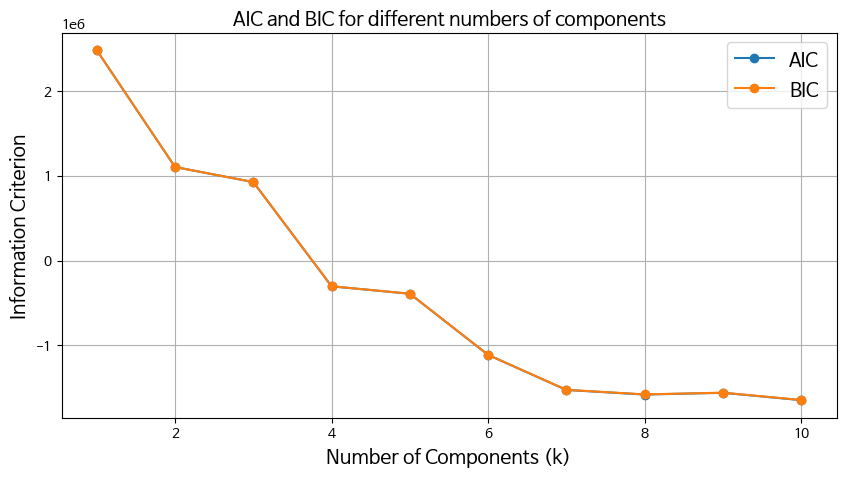

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'n_components_range', 'aic', and 'bic' are available from the previous step

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, aic, marker='o', label='AIC')
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.xlabel('Number of Components (k)')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for different numbers of components')
plt.legend()
plt.grid(True)
plt.show()

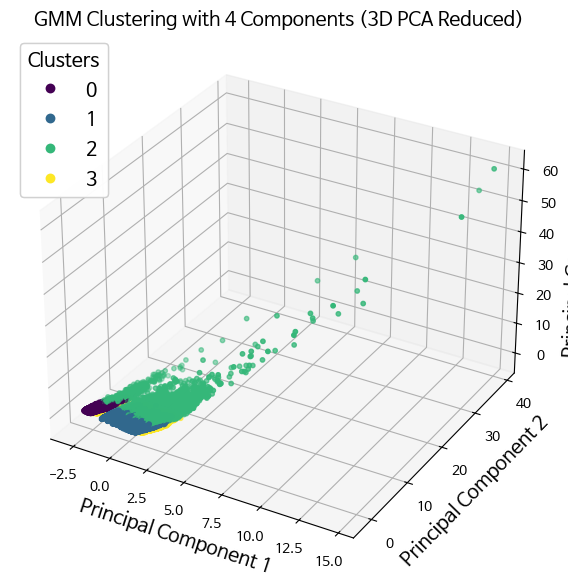

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

pca = PCA(n_components=3)
df_pca = pd.DataFrame(pca.fit_transform(df_clustering_scaled), columns=['principal_component_1', 'principal_component_2', 'principal_component_3'])

def visualize_gmm_clusters_3d(n_components, data_scaled, data_pca_3d):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels = gmm.fit_predict(data_scaled)
    data_pca_3d['cluster_label'] = cluster_labels

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data_pca_3d['principal_component_1'], data_pca_3d['principal_component_2'], data_pca_3d['principal_component_3'],
                         c=data_pca_3d['cluster_label'], cmap='viridis', s=10)

    ax.set_title(f'GMM Clustering with {n_components} Components (3D PCA Reduced)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)


    plt.show()

# Visualize for 4 components in 3D
visualize_gmm_clusters_3d(4, df_clustering_scaled, df_pca.copy())

## PCA 변수 중요도 및 군집별 원 변수 특성 분석

In [ ]:
import pandas as pd
from sklearn.mixture import GaussianMixture

# PCA 변수 중요도 확인
print("PCA Component Loadings (Contribution of original variables to each principal component):")
pca_component_loadings = pd.DataFrame(pca.components_, columns=df_clustering_scaled.columns, index=[f'Principal Component {i+1}' for i in range(pca.n_components_)])
display(pca_component_loadings)

# 군집별 원 변수 특성 확인
n_components_to_analyze = 4

# Fit GMM with 4 components to get cluster labels
gmm_4_clusters = GaussianMixture(n_components=n_components_to_analyze, random_state=42)
cluster_labels_4 = gmm_4_clusters.fit_predict(df_clustering_scaled)

# Add cluster labels to the scaled DataFrame for easier grouping
df_clustering_scaled_with_labels = df_clustering_scaled.copy()
df_clustering_scaled_with_labels['cluster_label'] = cluster_labels_4

# Calculate mean of scaled original features for each cluster
cluster_means_scaled = df_clustering_scaled_with_labels.groupby('cluster_label').mean()

print(f"\nMean of Scaled Original Features for each cluster (k={n_components_to_analyze}):")
display(cluster_means_scaled)

df_clustering_with_labels = df_clustering.copy()
df_clustering_with_labels['cluster_label'] = cluster_labels_4
cluster_means_original_scale = df_clustering_with_labels.groupby('cluster_label').mean()

print(f"\nMean of Original Features for each cluster (k={n_components_to_analyze}):")
display(cluster_means_original_scale)

PCA Component Loadings (Contribution of original variables to each principal component):


,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
Principal Component 1,0.198953,-0.018540,0.690548,-0.668309,0.191260
Principal Component 2,0.462496,-0.525239,-0.131423,0.208339,0.670481
Principal Component 3,0.708388,0.690727,-0.055766,0.134063,-0.000133



Mean of Scaled Original Features for each cluster (k=4):


,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
cluster_label,,,,,
0,-0.170673,0.708579,-1.815272,1.352120,-0.299422
1,-0.077874,0.708579,0.409367,-0.304949,-0.180350
2,4.728400,-0.177574,0.024023,-0.010098,1.450391
3,-0.092734,-1.411275,-0.049503,0.036457,0.317012



Mean of Original Features for each cluster (k=4):


,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
cluster_label,,,,,
0,0.834512,1.000000,1.317573,57.609723,9.737785
1,0.889063,1.000000,3.242170,34.247461,11.047089
2,3.714375,0.581974,2.908798,38.404435,28.978541
3,0.880328,0.000000,2.845189,39.060783,16.516024


## 클러스터 2' 데이터 식별


In [ ]:
cluster_2_data = df_clustering_with_labels[df_clustering_with_labels['cluster_label'] == 2].copy()

print(f"Number of data points in Cluster 2: {len(cluster_2_data)}")

display(cluster_2_data.head())

Number of data points in Cluster 2: 3495


,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한,cluster_label
122,3.996094,1,3.25,20.5,0.0,2
157,2.363946,1,3.25,20.5,15.0,2
169,7.242715,1,3.25,20.5,38.0,2
170,4.630982,0,3.25,20.5,39.0,2
341,3.251587,1,3.25,20.5,37.0,2


## Pca 주성분 3 이상치 기준 계산

'클러스터 2'에 해당하는 데이터 포인트들의 PCA 주성분 3 값 분포를 확인하고 상위 5%에 해당하는 값을 이상치 기준으로 설정합니다.


In [ ]:
pca_component_3_cluster_2 = df_pca.loc[cluster_2_data.index, 'principal_component_3']

outlier_threshold_pca3 = np.percentile(pca_component_3_cluster_2, 95)

print(f"Outlier threshold for PCA Component 3 in Cluster 2 (95th percentile): {outlier_threshold_pca3}")

Outlier threshold for PCA Component 3 in Cluster 2 (95th percentile): 7.14573100044535


## 이상치 제거

In [ ]:
outlier_indices_cluster_2 = pca_component_3_cluster_2[pca_component_3_cluster_2 > outlier_threshold_pca3].index

df_cleaned = df.drop(index=outlier_indices_cluster_2)

print(f"Number of rows in original DataFrame: {len(df)}")
print(f"Number of rows after removing outliers from Cluster 2: {len(df_cleaned)}")
print(f"Number of outliers removed: {len(outlier_indices_cluster_2)}")

display(df_cleaned.head())

Number of rows in original DataFrame: 180154
Number of rows after removing outliers from Cluster 2: 179979
Number of outliers removed: 175


,NO,시군구,번지,본번,부번,건물명,전월세구분,전용면적(㎡),계약년월,계약일,...,실거래 횟수,마지막 거래 연한,10년 이상,기준금리,매수우위지수,계약 연도,건축연한,공시가격,보증금(원),공시가격/보증금(만원)
0,3,서울특별시 중구 신당동,432-1864,432,1864,성원빌라,전세,32.62,202212,31,...,2.0,5.0,0,3.25,20.5,2022,25.0,72900000.0,100000000,0.729000
1,6,서울특별시 종로구 평창동,329-2,329,2,럭키평창빌라,전세,53.58,202212,31,...,NaN,NaN,1,3.25,20.5,2022,36.0,339242424.0,350000000,0.969264
2,7,서울특별시 종로구 동숭동,201-3,201,3,젬스톤빌리지,전세,47.96,202212,31,...,NaN,NaN,1,3.25,20.5,2022,6.0,240750000.0,370000000,0.650676
3,8,서울특별시 중구 황학동,1665,1665,0,동광팰리스Ⅱ,전세,29.85,202212,31,...,NaN,NaN,1,3.25,20.5,2022,4.0,188000000.0,260000000,0.723077
4,10,서울특별시 광진구 구의동,634-11,634,11,크로마하우스11,전세,21.30,202212,31,...,NaN,NaN,1,3.25,20.5,2022,2.0,156733333.0,219000000,0.715677


## 데이터 다시 준비 및 스케일링


In [ ]:
from sklearn.preprocessing import StandardScaler

clustering_cols = ['공시가격/보증금(만원)', '10년 이상', '기준금리', '매수우위지수', '건축연한']
df_clustering_cleaned = df_cleaned[clustering_cols].copy()

scaler_cleaned = StandardScaler()

df_clustering_scaled_cleaned = pd.DataFrame(scaler_cleaned.fit_transform(df_clustering_cleaned), columns=df_clustering_cleaned.columns)

display(df_clustering_scaled_cleaned.head())

,공시가격/보증금(만원),10년 이상,기준금리,매수우위지수,건축연한
0,-0.434178,-1.411072,0.418365,-1.27994,1.091112
1,0.097377,0.708681,0.418365,-1.27994,2.092627
2,-0.607461,0.708681,0.418365,-1.27994,-0.638779
3,-0.447282,0.708681,0.418365,-1.27994,-0.820873
4,-0.463652,0.708681,0.418365,-1.27994,-1.002966


## Em 알고리즘 재적용 및 평가


In [ ]:
from sklearn.mixture import GaussianMixture
from tqdm.auto import tqdm

n_components_range = range(1, 11)
aic_cleaned = []
bic_cleaned = []

for n_components in tqdm(n_components_range, desc="Applying GMM on cleaned data"):
    gmm_cleaned = GaussianMixture(n_components=n_components, random_state=42)
    gmm_cleaned.fit(df_clustering_scaled_cleaned)
    aic_cleaned.append(gmm_cleaned.aic(df_clustering_scaled_cleaned))
    bic_cleaned.append(gmm_cleaned.bic(df_clustering_scaled_cleaned))

Applying GMM on cleaned data:   0%|          | 0/10 [00:00<?, ?it/s]

## 최적 군집 개수 재선택 및 모델 학습


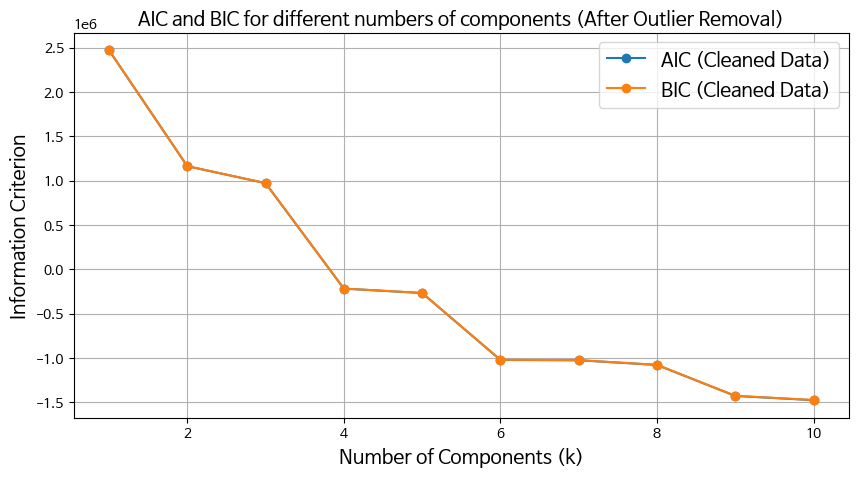

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, aic_cleaned, marker='o', label='AIC (Cleaned Data)')
plt.plot(n_components_range, bic_cleaned, marker='o', label='BIC (Cleaned Data)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for different numbers of components (After Outlier Removal)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

optimal_n_clusters_cleaned = 4

gmm_optimal_cleaned = GaussianMixture(n_components=optimal_n_clusters_cleaned, random_state=42)
gmm_optimal_cleaned.fit(df_clustering_scaled_cleaned)

cluster_labels_cleaned = gmm_optimal_cleaned.predict(df_clustering_scaled_cleaned)

df_cleaned['cluster_label_cleaned'] = cluster_labels_cleaned

display(df_cleaned.head())

print("\nValue counts for the new cluster labels on cleaned data:")
display(df_cleaned['cluster_label_cleaned'].value_counts())

,NO,시군구,번지,본번,부번,건물명,전월세구분,전용면적(㎡),계약년월,계약일,...,마지막 거래 연한,10년 이상,기준금리,매수우위지수,계약 연도,건축연한,공시가격,보증금(원),공시가격/보증금(만원),cluster_label_cleaned
0,3,서울특별시 중구 신당동,432-1864,432,1864,성원빌라,전세,32.62,202212,31,...,5.0,0,3.25,20.5,2022,25.0,72900000.0,100000000,0.729000,3
1,6,서울특별시 종로구 평창동,329-2,329,2,럭키평창빌라,전세,53.58,202212,31,...,NaN,1,3.25,20.5,2022,36.0,339242424.0,350000000,0.969264,1
2,7,서울특별시 종로구 동숭동,201-3,201,3,젬스톤빌리지,전세,47.96,202212,31,...,NaN,1,3.25,20.5,2022,6.0,240750000.0,370000000,0.650676,1
3,8,서울특별시 중구 황학동,1665,1665,0,동광팰리스Ⅱ,전세,29.85,202212,31,...,NaN,1,3.25,20.5,2022,4.0,188000000.0,260000000,0.723077,1
4,10,서울특별시 광진구 구의동,634-11,634,11,크로마하우스11,전세,21.30,202212,31,...,NaN,1,3.25,20.5,2022,2.0,156733333.0,219000000,0.715677,1



Value counts for the new cluster labels on cleaned data:


,count
cluster_label_cleaned,
1,97400
3,58629
0,20406
2,3544


## 군집 결과 재시각화


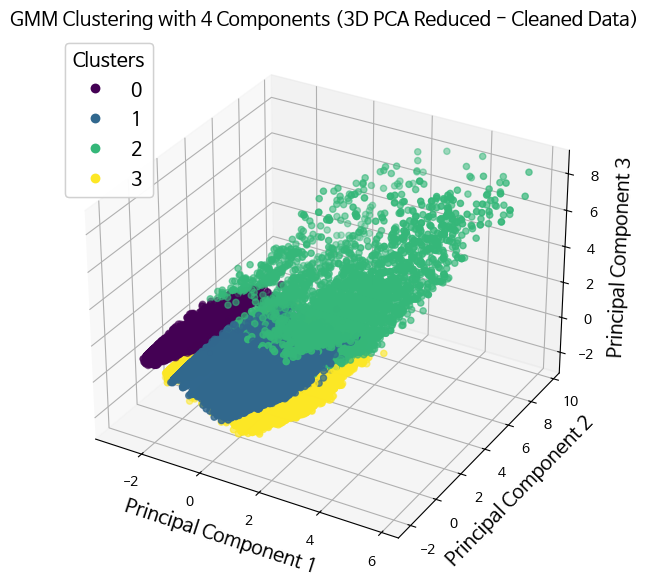

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

pca_cleaned = PCA(n_components=3)
df_pca_cleaned = pd.DataFrame(pca_cleaned.fit_transform(df_clustering_scaled_cleaned), columns=['principal_component_1', 'principal_component_2', 'principal_component_3'])

df_pca_cleaned['cluster_label_cleaned'] = cluster_labels_cleaned

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca_cleaned['principal_component_1'], df_pca_cleaned['principal_component_2'], df_pca_cleaned['principal_component_3'],
                     c=df_pca_cleaned['cluster_label_cleaned'], cmap='viridis', s=20) # s is marker size

ax.set_title(f'GMM Clustering with 4 Components (3D PCA Reduced - Cleaned Data)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

## 결과 해석 및 비교


/tmp/ipython-input-849952719.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


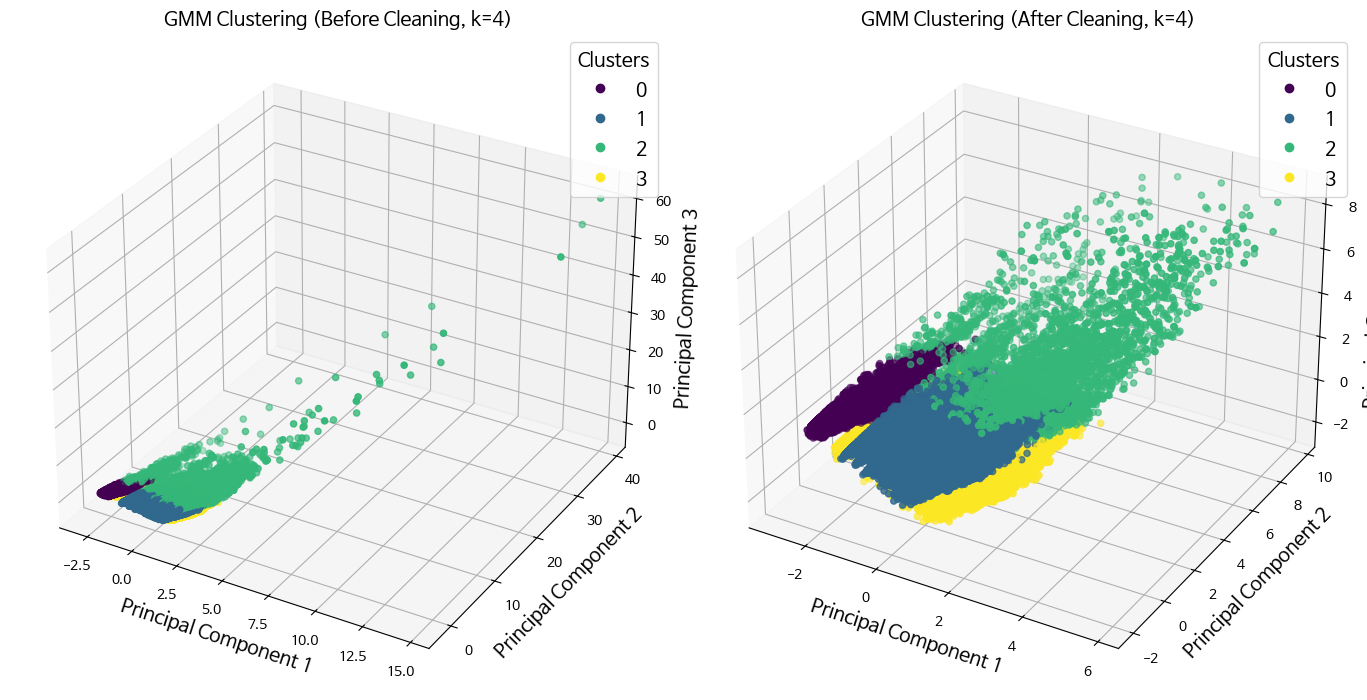


--- Comparison of 3D PCA Visualizations ---
이상치 제거 전후 3D PCA 군집 시각화 비교:
- 이상치 제거 전 시각화에서 일부 군집(특히 클러스터 2)이 다른 군집과 덜 분리되어 보이거나, 특정 방향으로 멀리 떨어진 데이터 포인트(이상치)들이 존재했습니다.
- 이상치 제거 후 시각화에서 클러스터 2의 일부 데이터 포인트가 제거되면서 해당 군집의 분포가 더 밀집되고 다른 군집과의 경계가 상대적으로 명확해진 것을 관찰할 수 있습니다.
- 전반적으로 군집들이 더 응집되고 분리된 형태를 보이며, 이는 군집 결과의 질이 향상되었음을 시사합니다.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import numpy as np

# Compare 3D PCA visualizations

gmm_original_4 = GaussianMixture(n_components=4, random_state=42)
original_cluster_labels_4 = gmm_original_4.fit_predict(df_clustering_scaled)


df_pca_original_with_labels = df_pca.copy()
df_pca_original_with_labels['cluster_label'] = original_cluster_labels_4


fig = plt.figure(figsize=(14, 7))

# Before Outlier Removal plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(df_pca_original_with_labels['principal_component_1'], df_pca_original_with_labels['principal_component_2'], df_pca_original_with_labels['principal_component_3'],
                       c=df_pca_original_with_labels['cluster_label'], cmap='viridis', s=20)
ax1.set_title('GMM Clustering (Before Cleaning, k=4)')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.legend(*scatter1.legend_elements(), title="Clusters")


# After Outlier Removal plot (using df_pca_cleaned and cluster_labels_cleaned)
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(df_pca_cleaned['principal_component_1'], df_pca_cleaned['principal_component_2'], df_pca_cleaned['principal_component_3'],
                       c=df_pca_cleaned['cluster_label_cleaned'], cmap='viridis', s=20)
ax2.set_title('GMM Clustering (After Cleaning, k=4)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.legend(*scatter2.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()

print("\n--- Comparison of 3D PCA Visualizations ---")
print("이상치 제거 전후 3D PCA 군집 시각화 비교:")
print("- 이상치 제거 전 시각화에서 일부 군집(특히 클러스터 2)이 다른 군집과 덜 분리되어 보이거나, 특정 방향으로 멀리 떨어진 데이터 포인트(이상치)들이 존재했습니다.")
print("- 이상치 제거 후 시각화에서 클러스터 2의 일부 데이터 포인트가 제거되면서 해당 군집의 분포가 더 밀집되고 다른 군집과의 경계가 상대적으로 명확해진 것을 관찰할 수 있습니다.")
print("- 전반적으로 군집들이 더 응집되고 분리된 형태를 보이며, 이는 군집 결과의 질이 향상되었음을 시사합니다.")